In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torch import nn
import cv2 as cv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from tqdm.auto import tqdm
import imageio

In [2]:
import zipfile
# Unzip Files
with zipfile.ZipFile('/kaggle/input/carvana-image-masking-challenge/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

with zipfile.ZipFile('/kaggle/input/carvana-image-masking-challenge/train_masks.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [3]:
os.listdir('/kaggle/working')

['__notebook__.ipynb', 'train', 'train_masks']

In [4]:
frames_path = '/kaggle/working/train'
masks_path = '/kaggle/working/train_masks'
len(os.listdir(frames_path)), len(os.listdir(masks_path))

(5088, 5088)

In [5]:
class MakeDataset(Dataset):
    def __init__(self, frames_path, masks_path, transform=None):
        self.frames_path = frames_path
        self.masks_path = masks_path
        self.transform = transform

        self.frame_names = sorted(os.listdir(frames_path))
        self.mask_names = sorted(os.listdir(masks_path))

    def __len__(self):
        return len(self.frame_names)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_path, self.frame_names[idx])
        mask_path = os.path.join(self.masks_path, self.mask_names[idx])

        frame = cv.imread(frame_path)
        gif_reader = imageio.get_reader(mask_path)
        single_frame = gif_reader.get_data(0)
        mask = cv.cvtColor(single_frame, cv.COLOR_RGB2BGR)
        mask = mask[:,:,0]
        mask[mask==255.0]=1.0

        frame = (frame).astype('float32')
        mask = (mask).astype('float32')

        if (self.transform):
            augmented = self.transform(image=frame, mask=mask)
            frame = augmented['image']
            mask = augmented['mask']

        width = 256
        height = 256
        dimensions = (width, height)

        frame = cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)
        mask = cv.resize(mask, dimensions, interpolation=cv.INTER_AREA)

        frame = transforms.ToTensor()(frame)
        mask = transforms.ToTensor()(mask)

        return frame, mask

In [6]:
dataset = MakeDataset(frames_path=frames_path,
                      masks_path=masks_path)

In [7]:
split = random_split(dataset, [0.8,0.2])

In [8]:
BATCH_SIZE = 4
train_dataloader = DataLoader(split[0],
                        batch_size=BATCH_SIZE,
                        shuffle=True)
val_dataloader = DataLoader(split[1],
                        batch_size=BATCH_SIZE,
                        shuffle=False)

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


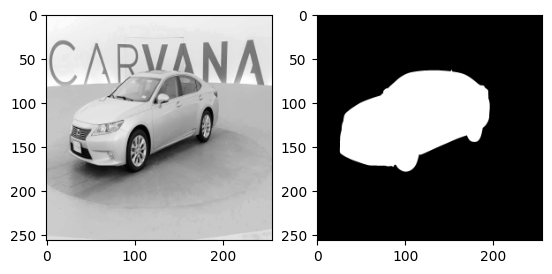

In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(train_features_batch.shape, train_labels_batch.shape)
plt.subplot(1,2,1)
plt.imshow(train_features_batch[0,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_labels_batch[0,0], cmap='gray')

In [10]:
train_features_batch.shape

torch.Size([4, 3, 256, 256])

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size = 3,stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

In [12]:
import torchvision.transforms as T
def copy_and_crop(down_layer, up_layer):
    b, ch, h, w = up_layer.shape
    crop = T.CenterCrop((h, w))(down_layer)
    return crop

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder = nn.ModuleList([
            DoubleConv(in_channels, 64),
            DoubleConv(64, 128),
            DoubleConv(128, 256),
            DoubleConv(256, 512)
        ])
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottle_neck = DoubleConv(512, 1024)
        
        self.up_samples = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])
        
        self.decoder = nn.ModuleList([
            DoubleConv(1024, 512),
            DoubleConv(512, 256),
            DoubleConv(256, 128),
            DoubleConv(128, 64)
        ])
        
        self.final_layer = nn.Conv2d(64, out_channels, 1, 1)
        
    def forward(self, x):
        skip_connections = []
        
        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottle_neck(x)
        
        for ind, layer in enumerate(self.decoder):
            x = self.up_samples[ind](x)
            y = copy_and_crop(skip_connections.pop(), x)
            x = layer(torch.cat([y, x], dim=1))
        
        x = self.final_layer(x)
        
        return x

In [14]:
def dice_score(preds, targets):
    preds = F.sigmoid(preds)
    preds = (preds > 0.5).float()
    score = (2. * (preds * targets).sum()) / (preds + targets).sum()
    return torch.mean(score).item()

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model = UNet(3,1).to(device)
if torch.cuda.device_count() > 1:
    unet_model = nn.DataParallel(unet_model, device_ids=[i for i in range(torch.cuda.device_count())])
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=unet_model.parameters(),
                            lr=1e-3)

In [16]:
epochs = 20
for epoch in tqdm(range(epochs)):
    dice = 0
    val_dice = 0
    for batch, (X, y) in tqdm(enumerate(train_dataloader)):
        unet_model.train()
        X = X.to(device)
        y = y.to(device)

        y_pred = unet_model(X).to(device)


        score = dice_score(y_pred, y)
        loss = loss_fn(y_pred, y)
        dice += score

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
    unet_model.eval()  
    print('Train Finished | Proceeding to test')
    with torch.inference_mode():
        for(X_val,y_val) in val_dataloader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            y_val_pred = unet_model(X_val)
            val_dice+=dice_score(y_val_pred,y_val) 

    dice/=(len(train_dataloader))
    val_dice/=len(val_dataloader)
    
    print(f'Epoch: {epoch+1} | Train Dice Score: {dice} | Val Dice Score: {val_dice}')

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 1 | Train Dice Score: 0.9650689300830332 | Val Dice Score: 0.9819357792536417


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 2 | Train Dice Score: 0.9849615510414064 | Val Dice Score: 0.9877380146699793


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 3 | Train Dice Score: 0.9862574733544895 | Val Dice Score: 0.7364518598014234


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 4 | Train Dice Score: 0.9873313527912897 | Val Dice Score: 0.9856296976407369


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 5 | Train Dice Score: 0.9897007861985204 | Val Dice Score: 0.9894079056440616


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 6 | Train Dice Score: 0.9899469187194098 | Val Dice Score: 0.9887345942796445


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 7 | Train Dice Score: 0.9909000920172056 | Val Dice Score: 0.9914899999020146


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 8 | Train Dice Score: 0.9907171729154344 | Val Dice Score: 0.9910241120001849


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 9 | Train Dice Score: 0.9917730030353037 | Val Dice Score: 0.9905844901122299


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 10 | Train Dice Score: 0.9921626299912428 | Val Dice Score: 0.9920656807282392


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 11 | Train Dice Score: 0.9903053630780143 | Val Dice Score: 0.9916988398514542


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 12 | Train Dice Score: 0.9923067947736189 | Val Dice Score: 0.9922809696664997


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 13 | Train Dice Score: 0.9907065673286648 | Val Dice Score: 0.9907835490563337


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 14 | Train Dice Score: 0.9919245257124686 | Val Dice Score: 0.9924921269510306


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 15 | Train Dice Score: 0.9925447084697618 | Val Dice Score: 0.9920256229007945


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 16 | Train Dice Score: 0.9927579923907994 | Val Dice Score: 0.9905695665116404


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 17 | Train Dice Score: 0.992710080502778 | Val Dice Score: 0.9926826745856042


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 18 | Train Dice Score: 0.9928070055009808 | Val Dice Score: 0.9929519917450699


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 19 | Train Dice Score: 0.9925847499684407 | Val Dice Score: 0.9908559848280514


0it [00:00, ?it/s]

Train Finished | Proceeding to test
Epoch: 20 | Train Dice Score: 0.9930261014018406 | Val Dice Score: 0.9930962034300261


In [17]:
with torch.inference_mode():
    X_test, y_test = next(iter(val_dataloader))
    X_test = X_test.to(device)
    y_pred = unet_model(X_test)
    y_pred = torch.nn.functional.sigmoid(y_pred)
    X_test = X_test.to('cpu').numpy()
    y_test = y_test.numpy()
    y_pred = y_pred.to('cpu').numpy()

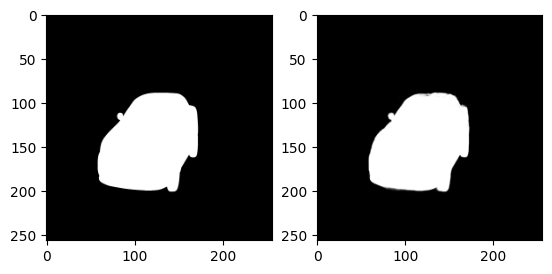

In [18]:
plt.subplot(1,2,1)
plt.imshow(y_test[0,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y_pred[0,0], cmap='gray')

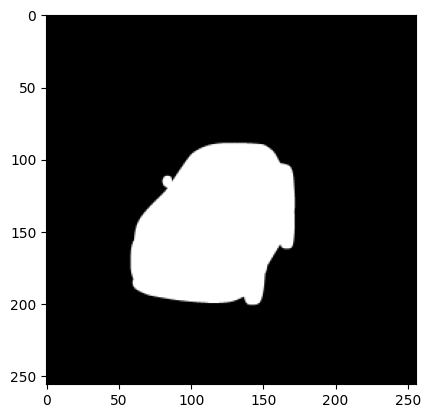

In [19]:
plt.imshow(y_test[0][0], cmap='gray')

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


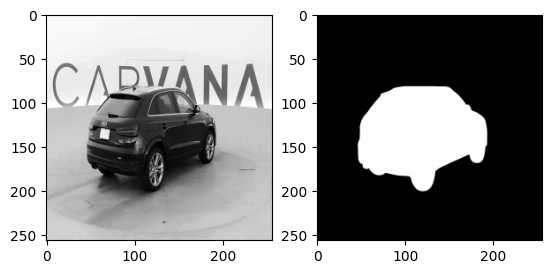

In [20]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(train_features_batch.shape, train_labels_batch.shape)
plt.subplot(1,2,1)
plt.imshow(train_features_batch[0,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_labels_batch[0,0], cmap='gray')

In [21]:
with zipfile.ZipFile('/kaggle/input/carvana-image-masking-challenge/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [22]:
class CarvanaTestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, self.images[index])
        
        image = cv.imread(img_path)[0]
        image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        width = 256
        height = 256
        dimensions = (width, height)

        image = cv.resize(image, dimensions, interpolation=cv.INTER_AREA)
        image = image.astype('float32')
        
        image = transforms.ToTensor()(image)

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations['image']

        return img_name, image

In [23]:
TEST_DIR = '/kaggle/working/test'
test_set = CarvanaTestDataset(image_dir=TEST_DIR)   

In [24]:
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

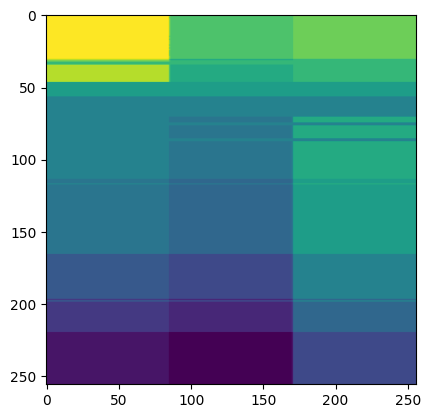

In [25]:
img = next(iter(test_loader))[1]
img = img.to(device)
mask = unet_model(img)
mask = torch.sigmoid(mask)
mask = (mask > 0.5).float() 

a = img[0].to('cpu').numpy()
b = mask[0].to('cpu').numpy()
# a = np.transpose(a[0], (1, 2, 0))
masked = cv.bitwise_and(a,b)
plt.imshow(a[0])

In [26]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[:-1:2]
    
    return ' '.join(str(x) for x in runs)

In [27]:
from pathlib import Path

def save_model(model, save_dir, model_name):
    directory_path = Path(save_dir)

    if not directory_path.exists():
        directory_path.mkdir(parents=True, exist_ok=True)
        print(f'Directory {directory_path} did not exist, so created')
    path = save_dir + '/' + model_name
    torch.save(model,path)
    print('Model saved successfully')

In [28]:
save_model(unet_model, '/kaggle/working', 'unet_carvana1')

Model saved successfully


In [29]:
unet_model.eval()

all_predictions = []
for img_names, x in tqdm(test_loader):
    x = x.to(device)
    with torch.inference_mode():
        preds = torch.sigmoid(unet_model(x))
        preds = (preds > 0.5).float()   
    preds = TF.resize(preds, size=(1280, 1918), interpolation=TF.InterpolationMode.NEAREST)
    
    for idx in range(len(img_names)):
        encoding = rle_encode(preds[idx].squeeze().cpu())
        all_predictions.append([img_names[idx], encoding])

  0%|          | 0/25016 [00:00<?, ?it/s]